In [1]:
# Konfigurasi Spark
import os
import sys

# 1. Mengeset variabel yang menyimpan lokasi di mana Spark diinstal
spark_path = "C:/spark"

# 2. Menentukan environment variable SPARK_HOME
os.environ['SPARK_HOME'] = spark_path

# 3. Simpan lokasi winutils.exe sebagai environment variable HADOOP_HOME
os.environ['HADOOP_HOME'] = spark_path

# 4. Lokasi Python yang dijalankan --> punya Anaconda
#    Apabila Python yang diinstall hanya Anaconda, maka tidak perlu menjalankan baris ini.
os.environ['PYSPARK_PYTHON'] = sys.executable

# 5. Konfigurasi path library PySpark
sys.path.append(spark_path + "/bin")
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/pyspark/")
sys.path.append(spark_path + "/python/lib")
sys.path.append(spark_path + "/python/lib/pyspark.zip")
sys.path.append(spark_path + "/python/lib/py4j-0.10.4-src.zip")

# 6. Import library Spark
#    Dua library yang WAJIB di-import adalah **SparkContext** dan **SparkConf**.
from pyspark import SparkContext
from pyspark import SparkConf

# Setting konfigurasi (opsional)
conf = SparkConf()
conf.set("spark.executor.memory", "2g")
conf.set("spark.cores.max", "4")

sc = SparkContext("local", conf=conf)
#    Apabila berhasil, maka ketika sc di-print akan mengeluarkan nilai <pyspark.context.SparkContext object>
print sc

In [2]:
from numpy import array
from math import sqrt
import re
import matplotlib.pyplot as plt
import numpy as np

from pyspark.mllib.clustering import KMeans, KMeansModel

In [3]:
data = sc.textFile('data/scrubbed.csv')

In [4]:
# Remove header
data = data.filter(lambda x:"latitude" not in x)

In [5]:
# Split and get latitude and longitude
parsedData = data.map(lambda row: array([x for x in row.split(',')[9:11]]))
# Clean Data
# Remove empty data
parsedData = parsedData.filter(lambda x:  x[0] != '' and x[0] != '0' and x[1] != '' and x[1] != '0')
# Filter data
# Only accept X and X.Y
parsedData = parsedData.filter(lambda x: re.match('^[-+]?[0-9]*\.?[0-9]+$', x[0]) and re.match('[-+]?[0-9]*\.?[0-9]+', x[1]))
# Cast to float
parsedData = parsedData.map(lambda x: array([float(x[0]), float(x[1])]))

In [6]:
clusters = KMeans.train(parsedData, 5, maxIterations=10, initializationMode="random")

In [7]:
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

In [8]:
WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 773596.38487


In [9]:
clusterData = parsedData.map(clusters.predict)

In [10]:
label = clusterData.collect()

In [11]:
parsedDataCollection = parsedData.collect()

In [12]:
parsedDataWithLabel = map(lambda(i,x): array([x[0], x[1], label[i]]), enumerate(parsedDataCollection))

In [13]:
colors = ['r', 'g', 'b', 'y', 'k']
shapes = ['.', 'o', 'v', '*', 'x']
for current in parsedDataWithLabel:
    plt.setp(plt.plot(current[0], current[1], shapes[int(current[2])]), color=colors[int(current[2])], linewidth=2.0)

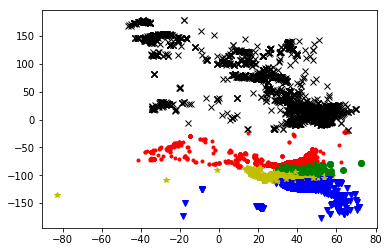

In [14]:
plt.show()